In [1]:
import torch
from torchopt import adamw
from tqdm.auto import tqdm
from optree import tree_map, tree_map_
import pickle
import matplotlib.pyplot as plt

import uqlib

from load import load_dataloaders, load_model

In [2]:
# Load data
train_dataloader, eval_dataloader = load_dataloaders(small=True)
num_data = len(train_dataloader.dataset)

In [3]:
# Load model (with standard Gaussian prior)
model, param_to_log_posterior = load_model(num_data=num_data)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Turn off Dropout
model.eval()

# Move to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device);

In [23]:
# Initiate variational parameters
init_mean = dict(model.named_parameters())
init_log_sds = tree_map(
    lambda x: (torch.zeros_like(x) - 2.0).requires_grad_(True), init_mean
)

In [24]:
init_log_sds

{'bert.embeddings.word_embeddings.weight': tensor([[-2., -2., -2.,  ..., -2., -2., -2.],
         [-2., -2., -2.,  ..., -2., -2., -2.],
         [-2., -2., -2.,  ..., -2., -2., -2.],
         ...,
         [-2., -2., -2.,  ..., -2., -2., -2.],
         [-2., -2., -2.,  ..., -2., -2., -2.],
         [-2., -2., -2.,  ..., -2., -2., -2.]], device='cuda:0',
        requires_grad=True),
 'bert.embeddings.position_embeddings.weight': tensor([[-2., -2., -2.,  ..., -2., -2., -2.],
         [-2., -2., -2.,  ..., -2., -2., -2.],
         [-2., -2., -2.,  ..., -2., -2., -2.],
         ...,
         [-2., -2., -2.,  ..., -2., -2., -2.],
         [-2., -2., -2.,  ..., -2., -2., -2.],
         [-2., -2., -2.,  ..., -2., -2., -2.]], device='cuda:0',
        requires_grad=True),
 'bert.embeddings.token_type_embeddings.weight': tensor([[-2., -2., -2.,  ..., -2., -2., -2.],
         [-2., -2., -2.,  ..., -2., -2., -2.]], device='cuda:0',
        requires_grad=True),
 'bert.embeddings.LayerNorm.weight': 

In [16]:
# Optimization setup
num_epochs = 4
num_training_steps = num_epochs * len(train_dataloader)

optimizer = adamw(lr=5e-2)
# optimizer = adamw(lr=lambda i: 1e-1 * (1 - i / num_training_steps))

In [17]:
# Optimize
vi_state = uqlib.vi.diag.init(init_mean, optimizer=optimizer, init_log_sds=init_log_sds)

progress_bar = tqdm(range(num_training_steps))

nelbos = []

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        vi_state = uqlib.vi.diag.update(
            vi_state, param_to_log_posterior, batch, optimizer, 1
        )
        print(vi_state.nelbo, end="\r")
        nelbos.append(vi_state.nelbo)
        progress_bar.update(1)

  0%|          | 0/500 [00:00<?, ?it/s]

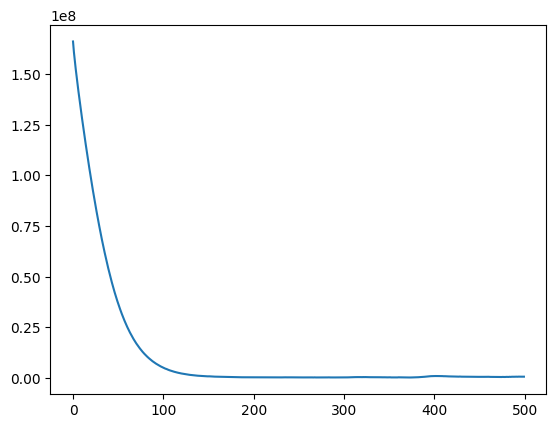

In [18]:
plt.plot(nelbos);

In [26]:
samps = uqlib.vi.diag.sample(vi_state)
samps

{'bert.embeddings.word_embeddings.weight': tensor([[ 2.0850e+00,  6.1591e-01, -1.6793e-01,  ..., -1.0362e+00,
           5.3880e-02,  1.3522e+00],
         [ 2.3799e+00, -5.2560e-01,  9.4559e-01,  ...,  1.0963e+00,
           3.3341e-01,  1.0846e+00],
         [ 1.2722e+00,  2.0818e-01,  1.1934e+00,  ...,  6.5740e-02,
          -9.2494e-01,  1.1870e+00],
         ...,
         [-4.1699e-01, -1.9577e+00,  9.3555e-01,  ..., -1.6141e-01,
          -8.9633e-01, -3.3470e-02],
         [ 4.8877e-01,  3.2324e-01,  9.6694e-01,  ...,  6.4392e-04,
           4.6544e-01,  1.9295e-01],
         [ 9.5075e-01, -5.9587e-01,  1.3428e+00,  ..., -7.4215e-01,
          -1.9442e+00, -1.9840e+00]], device='cuda:0', grad_fn=<AddBackward0>),
 'bert.embeddings.position_embeddings.weight': tensor([[-3.7888e-02, -3.7528e-01, -1.2114e+00,  ...,  8.7046e-01,
          -1.1299e+00, -1.2107e+00],
         [ 8.0408e-01,  5.5511e-01, -1.3349e+00,  ..., -1.5968e+00,
          -5.7307e-01,  3.1162e-01],
         [ 1.61

In [20]:
vi_state.mean

{'bert.embeddings.word_embeddings.weight': Parameter containing:
 tensor([[ 5.0889e-09, -2.7425e-09, -2.5586e-09,  ..., -7.5072e-09,
           7.7668e-07,  4.9459e-09],
         [-5.4634e-09,  4.9295e-09, -2.5979e-09,  ..., -1.0311e-07,
          -4.2829e-08, -3.7858e-09],
         [ 4.4325e-09,  1.2393e-09, -4.0207e-09,  ..., -1.4580e-08,
          -4.5513e-09, -4.6115e-10],
         ...,
         [ 2.4843e-08,  5.7233e-09, -6.5429e-09,  ..., -3.3961e-09,
           3.1063e-09,  5.7327e-09],
         [ 3.5873e-09, -5.3419e-09, -6.6253e-09,  ...,  3.5077e-09,
          -2.8038e-09,  5.4457e-09],
         [-1.4470e-08,  1.7322e-08,  9.2904e-10,  ..., -3.2749e-09,
           7.9507e-09, -2.7926e-07]], device='cuda:0', requires_grad=True),
 'bert.embeddings.position_embeddings.weight': Parameter containing:
 tensor([[-1.7708e-02,  2.0249e-02, -1.6093e-02,  ...,  5.9378e-03,
          -2.6984e-03, -1.6031e-02],
         [-4.8144e-02, -1.6310e-02,  2.8359e-02,  ...,  6.7984e-03,
          

In [22]:
sd_diag = tree_map(torch.exp, vi_state.log_sd_diag)
sd_diag

{'bert.embeddings.word_embeddings.weight': tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
        device='cuda:0', grad_fn=<ExpBackward0>),
 'bert.embeddings.position_embeddings.weight': tensor([[1.0075, 0.9972, 1.0051,  ..., 0.9997, 0.9968, 1.0122],
         [1.0027, 1.0100, 1.0148,  ..., 0.9850, 1.0123, 1.0035],
         [0.9798, 0.9828, 1.0473,  ..., 0.9769, 1.0030, 0.9954],
         ...,
         [0.9992, 1.0001, 1.0000,  ..., 1.0005, 1.0000, 0.9999],
         [1.0001, 1.0000, 1.0000,  ..., 1.0000, 1.0002, 1.0000],
         [0.9999, 0.9997, 0.9999,  ..., 0.9999, 1.0000, 0.9998]],
        device='cuda:0', grad_fn=<ExpBackward0>),
 '

In [11]:
# Save state
def detach(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu()


vi_state = tree_map_(detach, vi_state)
pickle.dump(vi_state, open("yelp_vi_state.pkl", "wb"))

In [10]:
# Alternative implementation that updates mu and log_sigma directly without using the
# uqlib init+update API

# from torch.optim import AdamW
# from transformers import get_scheduler


# mu = dict(model.named_parameters())
# log_sigma = tree_map(lambda x: torch.zeros_like(x, requires_grad=True), mu)

# vi_params_tensors = list(mu.values()) + list(log_sigma.values())

# vi_optimizer = AdamW(vi_params_tensors, lr=5e-5)
# vi_lr_scheduler = get_scheduler(
#     name="linear",
#     optimizer=vi_optimizer,
#     num_warmup_steps=0,
#     num_training_steps=num_training_steps,
# )

# progress_bar = tqdm(range(num_training_steps))

# nelbos = []

# # model.train()
# for epoch in range(num_epochs):
#     for batch in train_dataloader:
#         batch = {k: v.to(device) for k, v in batch.items()}
#         vi_optimizer.zero_grad()

#         sigma = tree_map(torch.exp, log_sigma)

#         nelbo = uqlib.vi.diag.nelbo(
#             mu,
#             sigma,
#             param_to_log_posterior,
#             batch,
#         )

#         nelbo.backward()
#         nelbos.append(nelbo.item())

#         vi_optimizer.step()
#         vi_lr_scheduler.step()
#         progress_bar.update(1)